In [34]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
dir = r'C:\Users\adity\Desktop\Pytorch workings\cats_new'
print(os.listdir(dir))

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg', '10015.jpg', '10016.jpg', '10017.jpg', '10018.jpg', '10019.jpg', '1002.jpg', '10020.jpg', '10021.jpg', '10022.jpg', '10023.jpg', '10024.jpg', '10025.jpg', '10026.jpg', '10027.jpg', '10028.jpg', '10029.jpg', '1003.jpg', '10030.jpg', '10031.jpg', '10032.jpg', '10033.jpg', '10034.jpg', '10035.jpg', '10036.jpg', '10037.jpg', '10038.jpg', '10039.jpg', '1004.jpg', '10040.jpg', '10041.jpg', '10042.jpg', '10043.jpg', '10044.jpg', '10045.jpg', '10046.jpg', '10047.jpg', '10048.jpg', '10049.jpg', '1005.jpg', '10050.jpg', '10051.jpg', '10052.jpg', '10053.jpg', '10054.jpg', '10055.jpg', '10056.jpg', '10057.jpg', '10058.jpg', '10059.jpg', '1006.jpg', '10060.jpg', '10061.jpg', '10062.jpg', '10063.jpg', '10064.jpg', '10065.jpg', '10066.jpg', '10067.jpg', '

In [36]:
print(os.listdir(dir+'/cats')[:20])

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg']


In [37]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [38]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [39]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

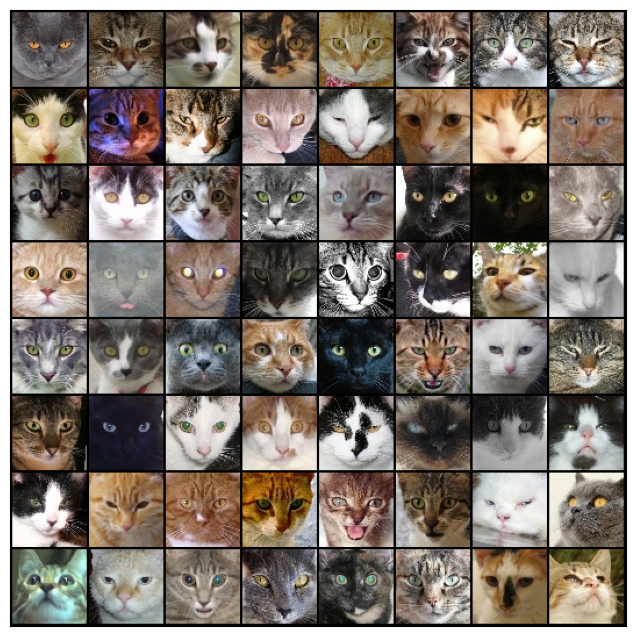

In [40]:
show_batch(train_dl)

In [41]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

In [42]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [43]:
is_cuda_available()

CUDA not available. Training on CPU!


device(type='cpu')

In [44]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA not available. Training on CPU!


In [45]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [46]:
discriminator = to_device(discriminator, device)

In [47]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


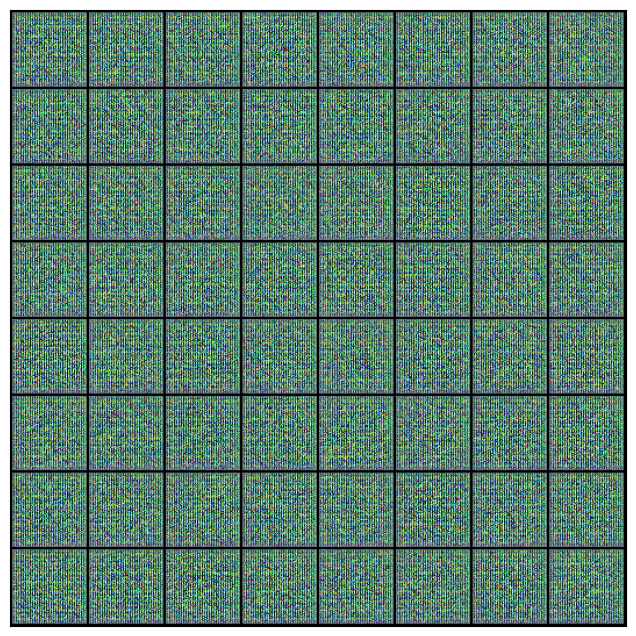

In [48]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [49]:
generator = to_device(generator, device)

In [50]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [51]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [52]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999546..0.9997407].


Saving generated-images-0000.png


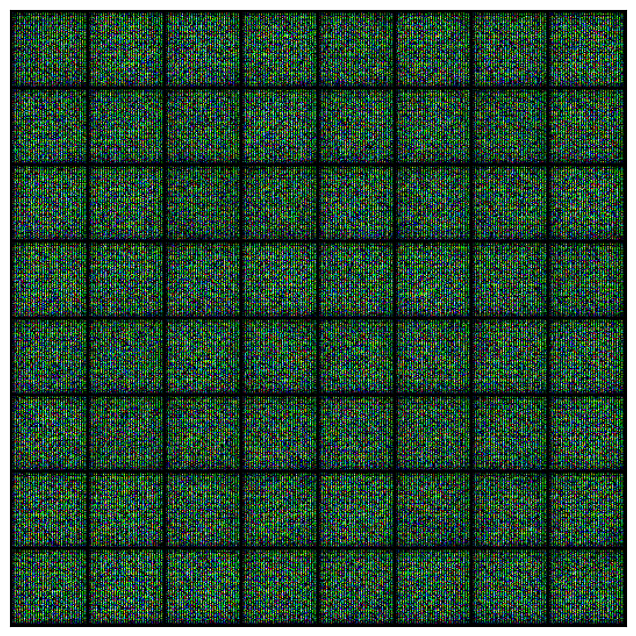

In [53]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


save_samples(0, fixed_latent)

In [54]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [55]:
lr = 0.0003
epochs = 60

In [56]:
history=fit(epochs,lr)



  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<22:27, 10.96s/it]

  2%|█▎                                                                                | 2/124 [00:15<14:27,  7.11s/it]

  2%|█▉                                                                                | 3/124 [00:20<12:08,  6.02s/it]

  3%|██▋                                                                               | 4/124 [00:24<10:50,  5.42s/it]

  4%|███▎                                                                              | 5/124 [00:29<10:05,  5.09s/it]

  5%|███▉                                                                              | 6/124 [00:33<09:47,  4.98s/it]

  6%|████▋                                                                             | 7/124 [00:38<09:31,  4.89s/it]

  6%|█████▎                   

Epoch [1/60], loss_g: 5.0628, loss_d: 1.4955, real_score: 0.7042, fake_score: 0.6041
Saving generated-images-0001.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:30, 10.49s/it]

  2%|█▎                                                                                | 2/124 [00:14<14:04,  6.92s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:31,  5.72s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:26,  5.22s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:47,  4.94s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:14,  4.70s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:52,  4.55s/it]

  6%|█████▎                   

Epoch [2/60], loss_g: 4.6680, loss_d: 1.5959, real_score: 0.6578, fake_score: 0.6217
Saving generated-images-0002.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:29, 10.48s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:59,  6.88s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:25,  5.66s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:01,  5.01s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:12,  4.64s/it]

  5%|███▉                                                                              | 6/124 [00:31<08:53,  4.52s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:38,  4.43s/it]

  6%|█████▎                   

Epoch [3/60], loss_g: 3.7978, loss_d: 0.5118, real_score: 0.7780, fake_score: 0.1891
Saving generated-images-0003.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:32, 10.02s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:21,  6.57s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:18,  5.61s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:13,  5.11s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:41,  4.89s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:19,  4.74s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:04,  4.65s/it]

  6%|█████▎                   

Epoch [4/60], loss_g: 6.6329, loss_d: 0.8743, real_score: 0.9139, fake_score: 0.4978
Saving generated-images-0004.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<22:00, 10.74s/it]

  2%|█▎                                                                                | 2/124 [00:15<14:50,  7.30s/it]

  2%|█▉                                                                                | 3/124 [00:20<12:33,  6.23s/it]

  3%|██▋                                                                               | 4/124 [00:25<11:24,  5.71s/it]

  4%|███▎                                                                              | 5/124 [00:30<10:43,  5.41s/it]

  5%|███▉                                                                              | 6/124 [00:34<10:00,  5.09s/it]

  6%|████▋                                                                             | 7/124 [00:39<09:40,  4.96s/it]

  6%|█████▎                   

Epoch [5/60], loss_g: 2.8132, loss_d: 0.2462, real_score: 0.8134, fake_score: 0.0321
Saving generated-images-0005.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:40, 10.57s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:30,  6.64s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:08,  5.52s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:09,  5.08s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:38,  4.86s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:17,  4.73s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:02,  4.64s/it]

  6%|█████▎                   

Epoch [6/60], loss_g: 7.4491, loss_d: 1.6782, real_score: 0.9955, fake_score: 0.7645
Saving generated-images-0006.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:45,  9.64s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:24,  6.59s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:07,  5.51s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:41,  4.84s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:02,  4.56s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:54,  4.53s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:41,  4.46s/it]

  6%|█████▎                   

Epoch [7/60], loss_g: 4.3716, loss_d: 0.7857, real_score: 0.8022, fake_score: 0.3696
Saving generated-images-0007.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:17,  9.90s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:14,  6.51s/it]

  2%|█▉                                                                                | 3/124 [00:17<10:40,  5.29s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:57,  4.98s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:28,  4.78s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:44,  4.44s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:33,  4.39s/it]

  6%|█████▎                   

Epoch [8/60], loss_g: 1.2950, loss_d: 1.4855, real_score: 0.3055, fake_score: 0.1707
Saving generated-images-0008.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:31,  9.52s/it]

  2%|█▎                                                                                | 2/124 [00:13<13:12,  6.49s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:09,  5.53s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:10,  5.09s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:36,  4.85s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:12,  4.69s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:55,  4.57s/it]

  6%|█████▎                   

Epoch [9/60], loss_g: 2.6447, loss_d: 1.1950, real_score: 0.4500, fake_score: 0.0198
Saving generated-images-0009.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:56,  9.72s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:21,  6.57s/it]

  2%|█▉                                                                                | 3/124 [00:18<10:57,  5.43s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:02,  5.02s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:07,  4.60s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:47,  4.47s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:29,  4.35s/it]

  6%|█████▎                   

Epoch [10/60], loss_g: 4.6070, loss_d: 0.1894, real_score: 0.9378, fake_score: 0.1143
Saving generated-images-0010.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:31, 10.01s/it]

  2%|█▎                                                                                | 2/124 [00:13<13:00,  6.40s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:02,  5.48s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:08,  5.07s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:35,  4.84s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:14,  4.70s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:36,  4.42s/it]

  6%|█████▎                   

Epoch [11/60], loss_g: 1.7915, loss_d: 1.5300, real_score: 0.3620, fake_score: 0.0276
Saving generated-images-0011.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:11,  9.85s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:29,  6.63s/it]

  2%|█▉                                                                                | 3/124 [00:18<10:57,  5.43s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:01,  5.01s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:26,  4.76s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:09,  4.66s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:56,  4.59s/it]

  6%|█████▎                   

Epoch [12/60], loss_g: 5.3928, loss_d: 4.5640, real_score: 0.0129, fake_score: 0.0001
Saving generated-images-0012.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:19,  9.92s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:32,  6.66s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:21,  5.63s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:19,  5.16s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:19,  4.70s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:00,  4.58s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:49,  4.53s/it]

  6%|█████▎                   

Epoch [13/60], loss_g: 4.2963, loss_d: 0.3823, real_score: 0.7452, fake_score: 0.0750
Saving generated-images-0013.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:47, 10.14s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:44,  6.76s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:27,  5.69s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:14,  5.12s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:37,  4.86s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:16,  4.71s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:57,  4.59s/it]

  6%|█████▎                   

Epoch [14/60], loss_g: 3.6123, loss_d: 0.2873, real_score: 0.8999, fake_score: 0.1554
Saving generated-images-0014.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:16,  9.89s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:14,  6.51s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:11,  5.55s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:14,  5.12s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:33,  4.82s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:13,  4.69s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:57,  4.59s/it]

  6%|█████▎                   

Epoch [15/60], loss_g: 5.7484, loss_d: 0.5222, real_score: 0.8576, fake_score: 0.2861
Saving generated-images-0015.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:58,  9.74s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:31,  6.65s/it]

  2%|█▉                                                                                | 3/124 [00:18<10:57,  5.43s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:43,  4.86s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:15,  4.67s/it]

  5%|███▉                                                                              | 6/124 [00:30<09:01,  4.59s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:51,  4.54s/it]

  6%|█████▎                   

Epoch [16/60], loss_g: 3.7613, loss_d: 0.1934, real_score: 0.9180, fake_score: 0.0989
Saving generated-images-0016.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:28,  9.99s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:41,  6.74s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:13,  5.56s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:02,  5.02s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:24,  4.74s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:04,  4.61s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:53,  4.56s/it]

  6%|█████▎                   

Epoch [17/60], loss_g: 5.5235, loss_d: 0.4079, real_score: 0.9901, fake_score: 0.3046
Saving generated-images-0017.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:31, 10.01s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:26,  6.61s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:19,  5.61s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:16,  5.14s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:42,  4.89s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:18,  4.74s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:03,  4.64s/it]

  6%|█████▎                   

Epoch [18/60], loss_g: 1.2314, loss_d: 0.7275, real_score: 0.6071, fake_score: 0.1654
Saving generated-images-0018.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:28,  9.50s/it]

  2%|█▎                                                                                | 2/124 [00:13<12:37,  6.21s/it]

  2%|█▉                                                                                | 3/124 [00:17<10:53,  5.40s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:03,  5.03s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:34,  4.82s/it]

  5%|███▉                                                                              | 6/124 [00:30<09:02,  4.60s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:47,  4.51s/it]

  6%|█████▎                   

Epoch [19/60], loss_g: 11.1868, loss_d: 0.6333, real_score: 1.0000, fake_score: 0.4437
Saving generated-images-0019.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:12,  9.86s/it]

  2%|█▎                                                                                | 2/124 [00:13<13:02,  6.41s/it]

  2%|█▉                                                                                | 3/124 [00:17<10:32,  5.23s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:47,  4.90s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:13,  4.65s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:35,  4.37s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:14,  4.22s/it]

  6%|█████▎                   

Epoch [20/60], loss_g: 4.8713, loss_d: 0.2844, real_score: 0.8342, fake_score: 0.0870
Saving generated-images-0020.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:59,  9.75s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:29,  6.63s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:21,  5.64s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:20,  5.17s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:43,  4.91s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:21,  4.75s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:04,  4.66s/it]

  6%|█████▎                   

Epoch [21/60], loss_g: 3.3213, loss_d: 0.1266, real_score: 0.9976, fake_score: 0.1113
Saving generated-images-0021.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:01, 10.26s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:48,  6.79s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:25,  5.67s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:21,  5.18s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:34,  4.83s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:15,  4.70s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:00,  4.62s/it]

  6%|█████▎                   

Epoch [22/60], loss_g: 6.8041, loss_d: 0.4402, real_score: 0.9911, fake_score: 0.3222
Saving generated-images-0022.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:48, 10.15s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:49,  6.80s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:33,  5.73s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:13,  5.11s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:38,  4.86s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:15,  4.71s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:59,  4.61s/it]

  6%|█████▎                   

Epoch [23/60], loss_g: 6.7097, loss_d: 0.3684, real_score: 0.7267, fake_score: 0.0019
Saving generated-images-0023.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:12<25:28, 12.43s/it]

  2%|█▎                                                                                | 2/124 [00:17<16:04,  7.90s/it]

  2%|█▉                                                                                | 3/124 [00:21<12:47,  6.35s/it]

  3%|██▋                                                                               | 4/124 [00:26<11:15,  5.63s/it]

  4%|███▎                                                                              | 5/124 [00:30<10:21,  5.22s/it]

  5%|███▉                                                                              | 6/124 [00:35<09:42,  4.93s/it]

  6%|████▋                                                                             | 7/124 [00:39<09:08,  4.69s/it]

  6%|█████▎                   

Epoch [24/60], loss_g: 0.2913, loss_d: 2.1947, real_score: 0.1215, fake_score: 0.0098
Saving generated-images-0024.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:11<23:09, 11.30s/it]

  2%|█▎                                                                                | 2/124 [00:16<15:11,  7.47s/it]

  2%|█▉                                                                                | 3/124 [00:20<12:29,  6.20s/it]

  3%|██▋                                                                               | 4/124 [00:25<11:16,  5.64s/it]

  4%|███▎                                                                              | 5/124 [00:30<10:30,  5.29s/it]

  5%|███▉                                                                              | 6/124 [00:34<10:02,  5.11s/it]

  6%|████▋                                                                             | 7/124 [00:39<09:42,  4.98s/it]

  6%|█████▎                   

Epoch [25/60], loss_g: 8.6150, loss_d: 0.8341, real_score: 0.9468, fake_score: 0.4903
Saving generated-images-0025.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:38,  9.58s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:21,  6.57s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:01,  5.47s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:46,  4.89s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:18,  4.69s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:45,  4.45s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:40,  4.45s/it]

  6%|█████▎                   

Epoch [26/60], loss_g: 4.1217, loss_d: 0.1281, real_score: 0.9726, fake_score: 0.0821
Saving generated-images-0026.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:49,  9.67s/it]

  2%|█▎                                                                                | 2/124 [00:13<12:38,  6.22s/it]

  2%|█▉                                                                                | 3/124 [00:17<10:39,  5.29s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:50,  4.92s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:23,  4.73s/it]

  5%|███▉                                                                              | 6/124 [00:30<09:07,  4.64s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:31,  4.37s/it]

  6%|█████▎                   

Epoch [27/60], loss_g: 5.6496, loss_d: 0.2232, real_score: 0.9960, fake_score: 0.1808
Saving generated-images-0027.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:29,  9.51s/it]

  2%|█▎                                                                                | 2/124 [00:13<13:01,  6.40s/it]

  2%|█▉                                                                                | 3/124 [00:18<10:59,  5.45s/it]

  3%|██▋                                                                               | 4/124 [00:21<09:42,  4.85s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:17,  4.68s/it]

  5%|███▉                                                                              | 6/124 [00:30<09:02,  4.60s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:31,  4.37s/it]

  6%|█████▎                   

Epoch [28/60], loss_g: 0.3053, loss_d: 0.7020, real_score: 0.5191, fake_score: 0.0299
Saving generated-images-0028.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:08,  9.82s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:20,  6.56s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:12,  5.56s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:47,  4.90s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:06,  4.60s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:30,  4.32s/it]

  6%|████▋                                                                             | 7/124 [00:34<08:28,  4.35s/it]

  6%|█████▎                   

Epoch [29/60], loss_g: 4.3905, loss_d: 0.4576, real_score: 0.6714, fake_score: 0.0016
Saving generated-images-0029.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:39,  9.59s/it]

  2%|█▎                                                                                | 2/124 [00:13<13:17,  6.54s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:16,  5.59s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:02,  5.02s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:26,  4.76s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:09,  4.65s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:37,  4.43s/it]

  6%|█████▎                   

Epoch [30/60], loss_g: 5.0514, loss_d: 6.2825, real_score: 0.0034, fake_score: 0.0000
Saving generated-images-0030.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:18,  9.91s/it]

  2%|█▎                                                                                | 2/124 [00:13<12:45,  6.27s/it]

  2%|█▉                                                                                | 3/124 [00:17<10:49,  5.37s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:58,  4.99s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:30,  4.79s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:10,  4.66s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:55,  4.58s/it]

  6%|█████▎                   

Epoch [31/60], loss_g: 3.7247, loss_d: 0.6248, real_score: 0.5413, fake_score: 0.0107
Saving generated-images-0031.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:41, 10.09s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:40,  6.72s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:29,  5.70s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:17,  5.15s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:38,  4.87s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:16,  4.72s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:56,  4.59s/it]

  6%|█████▎                   

Epoch [32/60], loss_g: 1.5378, loss_d: 1.6321, real_score: 0.3848, fake_score: 0.0055
Saving generated-images-0032.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:42, 10.10s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:45,  6.77s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:26,  5.67s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:19,  5.17s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:41,  4.89s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:13,  4.69s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:57,  4.60s/it]

  6%|█████▎                   

Epoch [33/60], loss_g: 4.1797, loss_d: 0.1940, real_score: 0.8664, fake_score: 0.0255
Saving generated-images-0033.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:20,  9.92s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:33,  6.67s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:19,  5.62s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:15,  5.13s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:28,  4.78s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:08,  4.65s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:54,  4.57s/it]

  6%|█████▎                   

Epoch [34/60], loss_g: 1.6707, loss_d: 0.4284, real_score: 0.7612, fake_score: 0.0751
Saving generated-images-0034.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<19:43,  9.62s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:19,  6.55s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:16,  5.59s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:07,  5.06s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:34,  4.83s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:13,  4.69s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:56,  4.59s/it]

  6%|█████▎                   

Epoch [35/60], loss_g: 0.0739, loss_d: 0.8341, real_score: 0.4629, fake_score: 0.0040
Saving generated-images-0035.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:22,  9.94s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:41,  6.74s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:30,  5.70s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:24,  5.20s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:45,  4.92s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:19,  4.74s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:02,  4.63s/it]

  6%|█████▎                   

Epoch [36/60], loss_g: 4.9177, loss_d: 0.1316, real_score: 0.9607, fake_score: 0.0803
Saving generated-images-0036.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:53, 10.19s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:46,  6.77s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:23,  5.65s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:21,  5.18s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:46,  4.93s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:20,  4.75s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:04,  4.65s/it]

  6%|█████▎                   

Epoch [37/60], loss_g: 3.4608, loss_d: 0.2115, real_score: 0.9076, fake_score: 0.0986
Saving generated-images-0037.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:27,  9.98s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:42,  6.74s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:31,  5.71s/it]

  3%|██▋                                                                               | 4/124 [00:22<09:57,  4.98s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:30,  4.80s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:08,  4.65s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:55,  4.57s/it]

  6%|█████▎                   

Epoch [38/60], loss_g: 4.5547, loss_d: 0.1673, real_score: 0.9802, fake_score: 0.1220
Saving generated-images-0038.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:52, 10.18s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:40,  6.72s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:29,  5.70s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:25,  5.22s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:44,  4.91s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:21,  4.76s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:06,  4.67s/it]

  6%|█████▎                   

Epoch [39/60], loss_g: 5.7827, loss_d: 0.1986, real_score: 0.9728, fake_score: 0.1479
Saving generated-images-0039.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:37, 10.06s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:48,  6.79s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:28,  5.69s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:24,  5.20s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:48,  4.94s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:24,  4.78s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:06,  4.67s/it]

  6%|█████▎                   

Epoch [40/60], loss_g: 0.2973, loss_d: 2.8190, real_score: 0.0960, fake_score: 0.0004
Saving generated-images-0040.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:30, 10.01s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:44,  6.76s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:33,  5.73s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:25,  5.22s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:48,  4.95s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:24,  4.79s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:59,  4.61s/it]

  6%|█████▎                   

Epoch [41/60], loss_g: 4.3084, loss_d: 0.1117, real_score: 0.9696, fake_score: 0.0626
Saving generated-images-0041.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:52, 10.18s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:55,  6.84s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:23,  5.65s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:21,  5.18s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:42,  4.89s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:20,  4.75s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:00,  4.62s/it]

  6%|█████▎                   

Epoch [42/60], loss_g: 5.2695, loss_d: 0.0800, real_score: 0.9860, fake_score: 0.0608
Saving generated-images-0042.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:40, 10.08s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:49,  6.80s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:35,  5.74s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:30,  5.25s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:51,  4.97s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:14,  4.70s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:01,  4.63s/it]

  6%|█████▎                   

Epoch [43/60], loss_g: 2.5296, loss_d: 1.4281, real_score: 0.3769, fake_score: 0.0074
Saving generated-images-0043.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:42, 10.10s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:51,  6.82s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:36,  5.76s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:31,  5.26s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:53,  4.98s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:27,  4.81s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:06,  4.67s/it]

  6%|█████▎                   

Epoch [44/60], loss_g: 3.6594, loss_d: 0.2718, real_score: 0.8160, fake_score: 0.0566
Saving generated-images-0044.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:42, 10.10s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:24,  6.59s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:21,  5.63s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:21,  5.18s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:47,  4.93s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:24,  4.78s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:08,  4.69s/it]

  6%|█████▎                   

Epoch [45/60], loss_g: 3.6536, loss_d: 0.4494, real_score: 0.6617, fake_score: 0.0104
Saving generated-images-0045.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:43, 10.11s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:49,  6.80s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:35,  5.75s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:29,  5.25s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:52,  4.98s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:26,  4.80s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:07,  4.68s/it]

  6%|█████▎                   

Epoch [46/60], loss_g: 5.7509, loss_d: 0.2515, real_score: 0.9838, fake_score: 0.1888
Saving generated-images-0046.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:39, 10.08s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:25,  6.60s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:20,  5.62s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:19,  5.16s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:40,  4.88s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:18,  4.73s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:02,  4.64s/it]

  6%|█████▎                   

Epoch [47/60], loss_g: 9.2585, loss_d: 0.5196, real_score: 0.9734, fake_score: 0.2812
Saving generated-images-0047.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:26<53:42, 26.20s/it]

  2%|█▎                                                                                | 2/124 [00:36<33:54, 16.68s/it]

  2%|█▉                                                                                | 3/124 [00:46<27:27, 13.62s/it]

  3%|██▋                                                                               | 4/124 [00:56<24:18, 12.16s/it]

  4%|███▎                                                                              | 5/124 [01:05<22:28, 11.33s/it]

  5%|███▉                                                                              | 6/124 [01:16<21:30, 10.93s/it]

  6%|████▋                                                                             | 7/124 [01:26<20:47, 10.66s/it]

  6%|█████▎                   

Epoch [48/60], loss_g: 3.0245, loss_d: 0.4137, real_score: 0.7394, fake_score: 0.0482
Saving generated-images-0048.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<22:22, 10.91s/it]

  2%|█▎                                                                                | 2/124 [00:15<14:28,  7.12s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:58,  5.94s/it]

  3%|██▋                                                                               | 4/124 [00:24<10:43,  5.36s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:50,  4.97s/it]

  5%|███▉                                                                              | 6/124 [00:33<09:27,  4.81s/it]

  6%|████▋                                                                             | 7/124 [00:37<09:10,  4.70s/it]

  6%|█████▎                   

Epoch [49/60], loss_g: 2.9013, loss_d: 0.3900, real_score: 0.7159, fake_score: 0.0274
Saving generated-images-0049.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:55, 10.20s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:53,  6.83s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:36,  5.76s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:29,  5.25s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:50,  4.96s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:22,  4.77s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:05,  4.67s/it]

  6%|█████▎                   

Epoch [50/60], loss_g: 1.9857, loss_d: 0.3545, real_score: 0.7571, fake_score: 0.0498
Saving generated-images-0050.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:02, 10.26s/it]

  2%|█▎                                                                                | 2/124 [00:14<14:03,  6.92s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:46,  5.84s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:16,  5.14s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:44,  4.91s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:08,  4.65s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:44,  4.48s/it]

  6%|█████▎                   

Epoch [51/60], loss_g: 2.7672, loss_d: 0.5219, real_score: 0.7453, fake_score: 0.0545
Saving generated-images-0051.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:39, 10.08s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:11,  6.49s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:05,  5.50s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:12,  5.11s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:17,  4.68s/it]

  5%|███▉                                                                              | 6/124 [00:30<08:51,  4.51s/it]

  6%|████▋                                                                             | 7/124 [00:35<08:42,  4.47s/it]

  6%|█████▎                   

Epoch [52/60], loss_g: 8.3767, loss_d: 0.4304, real_score: 0.9734, fake_score: 0.2734
Saving generated-images-0052.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:18, 10.40s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:27,  6.62s/it]

  2%|█▉                                                                                | 3/124 [00:18<11:10,  5.54s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:15,  5.13s/it]

  4%|███▎                                                                              | 5/124 [00:27<09:40,  4.88s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:21,  4.76s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:12,  4.72s/it]

  6%|█████▎                   

Epoch [53/60], loss_g: 5.9286, loss_d: 0.1463, real_score: 0.9818, fake_score: 0.1107
Saving generated-images-0053.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:09<20:05,  9.80s/it]

  2%|█▎                                                                                | 2/124 [00:13<13:10,  6.48s/it]

  2%|█▉                                                                                | 3/124 [00:18<10:58,  5.44s/it]

  3%|██▋                                                                               | 4/124 [00:22<10:04,  5.04s/it]

  4%|███▎                                                                              | 5/124 [00:26<09:29,  4.78s/it]

  5%|███▉                                                                              | 6/124 [00:31<09:09,  4.66s/it]

  6%|████▋                                                                             | 7/124 [00:36<09:08,  4.69s/it]

  6%|█████▎                   

Epoch [54/60], loss_g: 2.4445, loss_d: 0.3873, real_score: 0.7237, fake_score: 0.0409
Saving generated-images-0054.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:54, 10.20s/it]

  2%|█▎                                                                                | 2/124 [00:14<14:01,  6.90s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:48,  5.86s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:24,  5.20s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:48,  4.95s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:32,  4.85s/it]

  6%|████▋                                                                             | 7/124 [00:37<09:16,  4.75s/it]

  6%|█████▎                   

Epoch [55/60], loss_g: 0.1164, loss_d: 2.5942, real_score: 0.0914, fake_score: 0.0238
Saving generated-images-0055.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:11<22:42, 11.08s/it]

  2%|█▎                                                                                | 2/124 [00:15<14:53,  7.32s/it]

  2%|█▉                                                                                | 3/124 [00:20<12:22,  6.13s/it]

  3%|██▋                                                                               | 4/124 [00:25<11:07,  5.56s/it]

  4%|███▎                                                                              | 5/124 [00:29<10:14,  5.16s/it]

  5%|███▉                                                                              | 6/124 [00:34<09:50,  5.00s/it]

  6%|████▋                                                                             | 7/124 [00:38<09:29,  4.87s/it]

  6%|█████▎                   

Epoch [56/60], loss_g: 0.2412, loss_d: 1.5915, real_score: 0.4102, fake_score: 0.0523
Saving generated-images-0056.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:39, 10.56s/it]

  2%|█▎                                                                                | 2/124 [00:15<14:43,  7.24s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:58,  5.94s/it]

  3%|██▋                                                                               | 4/124 [00:24<10:40,  5.34s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:56,  5.01s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:05,  4.63s/it]

  6%|████▋                                                                             | 7/124 [00:36<08:39,  4.44s/it]

  6%|█████▎                   

Epoch [57/60], loss_g: 0.8467, loss_d: 0.6832, real_score: 0.5794, fake_score: 0.0653
Saving generated-images-0057.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<21:38, 10.55s/it]

  2%|█▎                                                                                | 2/124 [00:15<14:35,  7.18s/it]

  2%|█▉                                                                                | 3/124 [00:20<12:16,  6.08s/it]

  3%|██▋                                                                               | 4/124 [00:24<11:03,  5.53s/it]

  4%|███▎                                                                              | 5/124 [00:29<10:14,  5.17s/it]

  5%|███▉                                                                              | 6/124 [00:33<09:44,  4.96s/it]

  6%|████▋                                                                             | 7/124 [00:38<09:24,  4.83s/it]

  6%|█████▎                   

Epoch [58/60], loss_g: 4.3186, loss_d: 0.2565, real_score: 0.8202, fake_score: 0.0416
Saving generated-images-0058.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:50, 10.17s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:48,  6.79s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:36,  5.75s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:32,  5.27s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:54,  5.00s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:30,  4.84s/it]

  6%|████▋                                                                             | 7/124 [00:37<09:14,  4.74s/it]

  6%|█████▎                   

Epoch [59/60], loss_g: 1.5326, loss_d: 0.7749, real_score: 0.6080, fake_score: 0.0192
Saving generated-images-0059.png




  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/124 [00:10<20:48, 10.15s/it]

  2%|█▎                                                                                | 2/124 [00:14<13:54,  6.84s/it]

  2%|█▉                                                                                | 3/124 [00:19<11:38,  5.77s/it]

  3%|██▋                                                                               | 4/124 [00:23<10:33,  5.28s/it]

  4%|███▎                                                                              | 5/124 [00:28<09:54,  5.00s/it]

  5%|███▉                                                                              | 6/124 [00:32<09:30,  4.83s/it]

  6%|████▋                                                                             | 7/124 [00:37<09:12,  4.72s/it]

  6%|█████▎                   

Epoch [60/60], loss_g: 5.3555, loss_d: 0.1378, real_score: 0.9984, fake_score: 0.1195
Saving generated-images-0060.png


In [57]:
losses_g, losses_d, real_scores, fake_scores = history

In [58]:
from IPython.display import Image

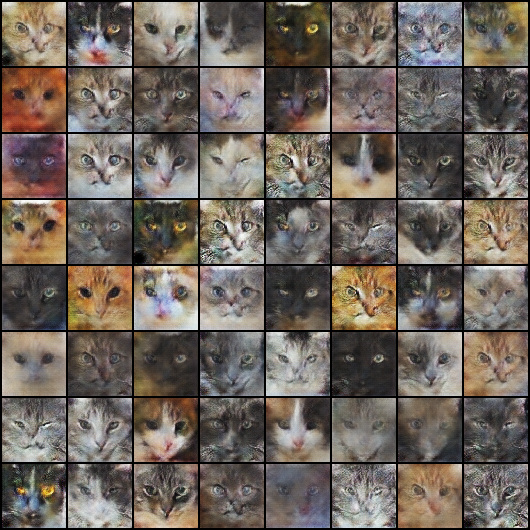

In [59]:
Image('./generated/generated-images-0033.png')

In [60]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

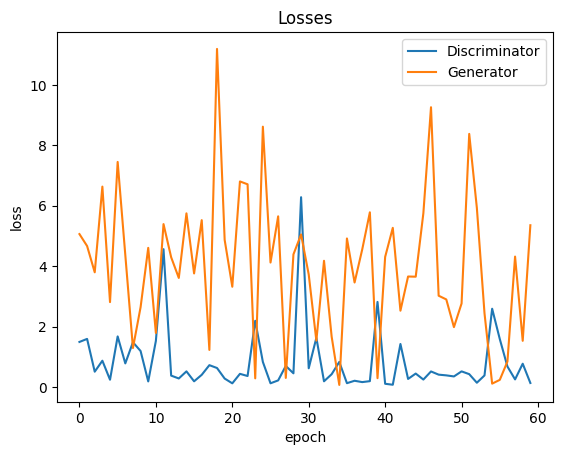

In [61]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

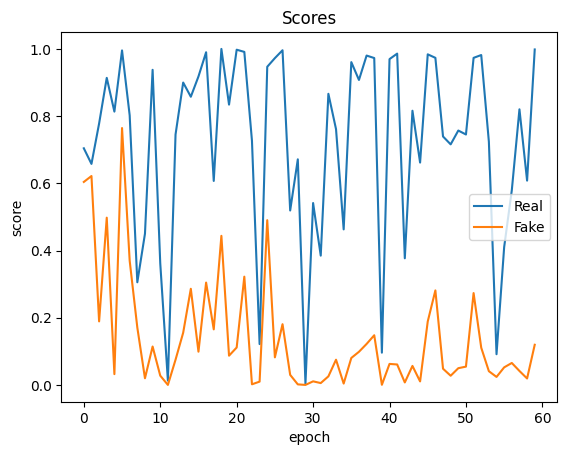

In [64]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88002217..0.8068803].


Saving generated-images-0000.png


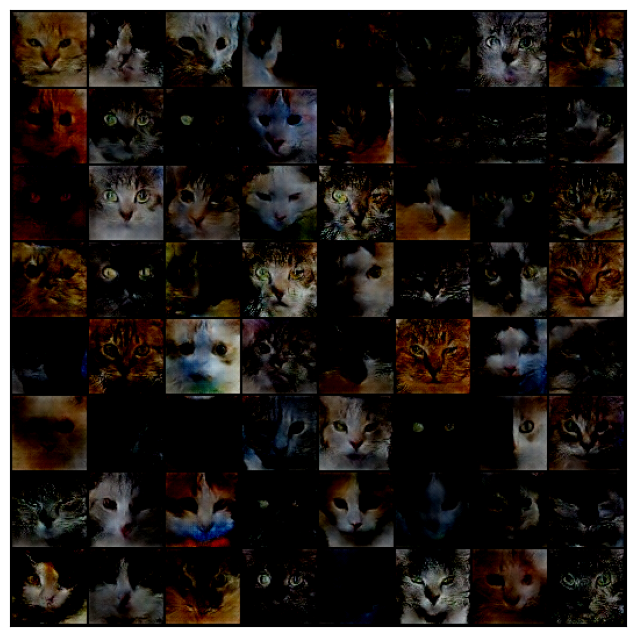

In [63]:
save_samples(0, fixed_latent)